## Tabular Solution with Q-Learning

First we import the model of our environment and the tabular Q-learning algorithm.

In [36]:
from mdp import GymFarmEnv
import Q
import numpy as np

We initialise an environment with ``alpha = 0.1`` and ``beta = 0.5``.

As a reminder, this means that there is a 10 % chance that growing wheat returns 0 € and a 50 % chance that a pair of sheep will multiply and generate an additional sheep.

In [37]:
env = GymFarmEnv(alpha=0.1, beta=0.5)

We initialise a Q-learning table with dimensions as the number of bins defined in the environment model. This means that instead of learning and storing a Q-value for an effectively continuous state space (with potential maximum values for amount of money and sheep owned), we discretize the space by putting the actual values of the state into bins so that each state can be visited sufficiently often in the learning process. The bins are defined as follows (for more details and how states are put into bins see ``mdp.py``):

```
self.n_sheep_bins = [0, 1, 2, 3, 4, 5, 10]
self.money_bins = [0, 1000, 2000, 3000]
self.year_bins = [0, 1, 2, 3, 4, 5, 10, 20, 30]
```

In [38]:
states_dim = (len(env.n_sheep_bins), len(env.money_bins), len(env.year_bins))
actions_dim = env.action_space.n
Q_table = Q.init_q_table(states_dim, actions_dim)

## Training

We train the Q-learning algorithm (for implementation details see ``Q.py``).

In [39]:
trained_Q_table, train_stats = Q.train(
    n_training_episodes=100000,
    min_epsilon=0.05,
    max_epsilon=0.5,
    decay_rate=0.0001,
    alpha=0.1,
    gamma=0.99,
    env = env,
    max_steps=1000,
    Q_table=Q_table,
    render=False
)

  0%|          | 0/100000 [00:00<?, ?it/s]

Let's see some stats for the training process.

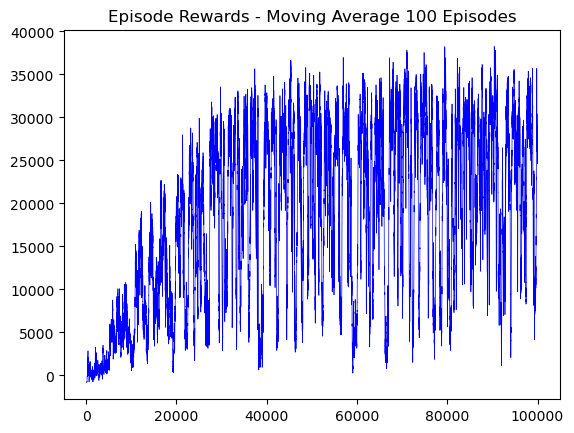

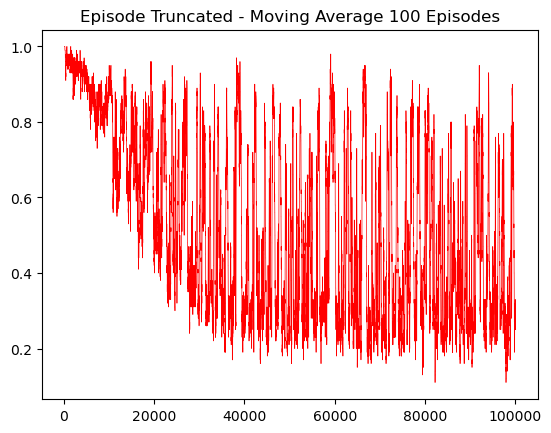

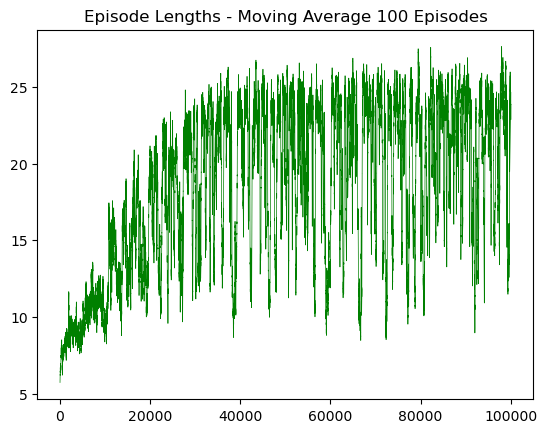

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def get_total_episode_reward(episode):
    total_reward = sum(step['reward'] for step in episode)
    return total_reward

def get_mean_episode_reward(all_episodes):
    mean_episode_reward = np.mean([get_total_episode_reward(episode) for episode in all_episodes])
    return mean_episode_reward

def get_episode_length(episode):
    episode_length = len(episode)
    return episode_length

def plot_episode_lengths(stats):
    episode_lengths = [get_episode_length(episode) for episode in stats]
    episode_lengths = pd.Series(episode_lengths)
    smoothed_episode_lengths = episode_lengths.rolling(window=100).mean()
    plot = plt.plot(smoothed_episode_lengths, 'g', lw=0.5)
    plt.title("Episode Lengths - Moving Average 100 Episodes")
    plt.show()

def plot_rewards(stats):
    # sns.set_theme(style="whitegrid")
    rewards = [get_total_episode_reward(episode) for episode in stats]
    plot = plt.plot(rewards, 'b', lw=0.5)
    plt.show()

def plot_rewards_moving_avg(stats):
    # sns.set_theme(style="whitegrid")
    rewards = [get_total_episode_reward(episode) for episode in stats]
    rewards = pd.Series(rewards)
    smoothed_rewards = rewards.rolling(window=100).mean()
    plot = plt.plot(smoothed_rewards, 'b', lw=0.5)
    plt.title("Episode Rewards - Moving Average 100 Episodes")
    plt.show()

def plot_truncated_moving_avg(stats):
    truncated_list = [sum(step['truncated'] for step in episode) > 0 for episode in stats]
    truncated_list = pd.Series(truncated_list)
    smoothed_truncated_list = truncated_list.rolling(window=100).mean()
    plot = plt.plot(smoothed_truncated_list, 'r', lw=0.5)
    plt.title("Episode Truncated - Moving Average 100 Episodes")
    plt.show()

plot_rewards_moving_avg(train_stats)
plot_truncated_moving_avg(train_stats)
plot_episode_lengths(train_stats)

On first glance seems highly unstable (note that we're already taking moving averages of 100 episodes).

## Testing

We evaluate the performance of the trained agent by using the trained Q-table on 1000 episodes and taking the average total reward. Evaluating the performance over multiple episodes is crucial since our environment is not deterministic.

### Performance

In [41]:
test_stats = Q.eval_agent(
    env=env,
    max_steps=1000,
    n_eval_episodes=1000,
    Q_table=trained_Q_table,
    seed=None,
    render=False
)

# def get_total_episode_reward(episode):
#     total_reward = sum(step['reward'] for step in episode)
#     return total_reward

# def get_mean_episode_reward(all_episodes):
#     mean_episode_reward = np.mean([get_total_episode_reward(episode) for episode in all_episodes])
#     return mean_episode_reward

# get_mean_episode_reward(test_stats)

Mean Reward: 33032.23, Std Reward: 18712.731311251708


### Actions

Let's see which actions are taken at which steps. To do that we take the action statistics of the testing process and calculate proportions of actions taken in each step over the 1000 episodes played. Action 0 represents buying a sheep and action 1 growing wheat.

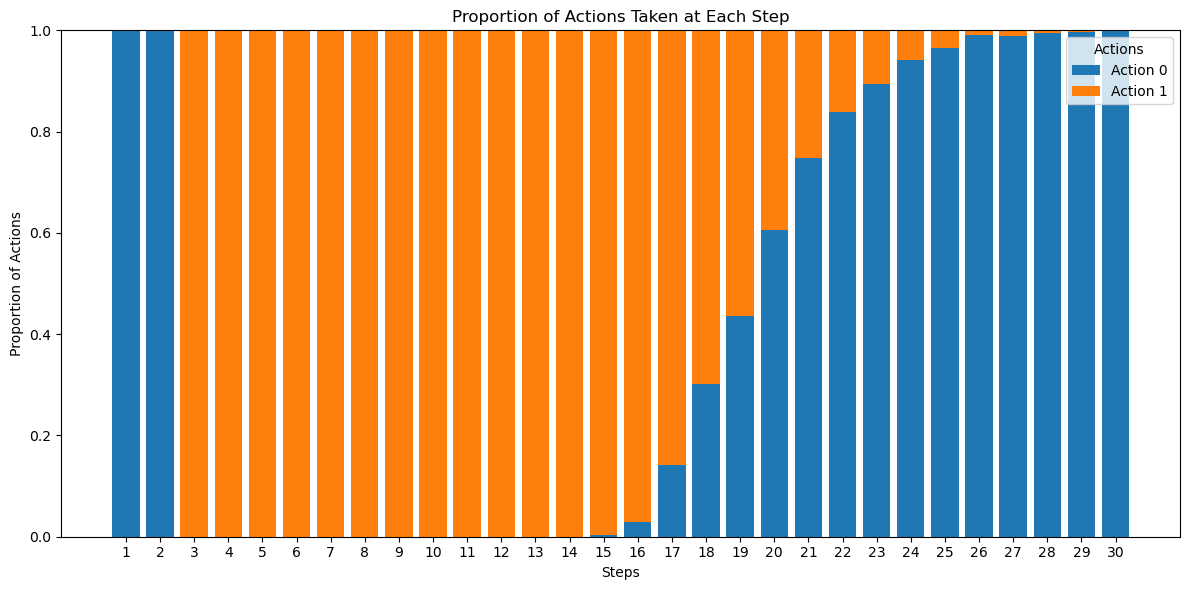

In [43]:
# We want the overall proportions of actions taken in each step for the episodes in the test statistics

import matplotlib.pyplot as plt
import numpy as np

step_action_counts = [[0, 0] for _ in range(30)]

for episode in test_stats:
    for step in range(len(episode)):
        if episode[step]['action'] == 0:
            step_action_counts[step][0] += 1
        else:
            step_action_counts[step][1] += 1

step_action_0_prop = np.array([step[0] / sum(step) for step in step_action_counts])
step_action_1_prop = np.array([step[1] / sum(step) for step in step_action_counts])
step_indices = np.arange(1, 31)

# Plotting the stacked bar chart
plt.figure(figsize=(12, 6))
plt.bar(step_indices, step_action_0_prop, label="Action 0")
plt.bar(step_indices, step_action_1_prop, bottom=step_action_0_prop, label="Action 1")

# Chart labels and title
plt.xlabel("Steps")
plt.ylabel("Proportion of Actions")
plt.title("Proportion of Actions Taken at Each Step")
plt.xticks(step_indices)
plt.legend(title="Actions")
plt.tight_layout()
plt.show()

### Evaluating performance for different environment parameters

We would like to see how the performance of our algorithm varies for different environment parameters.

In [7]:
alphas = [0.1, 0.2, 0.3, 0.4, 0.5]
betas = [0.5, 0.4, 0.3, 0.2, 0.1]

rewards = {
    'alpha': [],
    'beta': [],
    'reward': []
}

for alpha in alphas:
    for beta in betas:
        # env = GymFarmEnv(alpha=alpha, beta=beta, max_sheep=10000, max_money=10000, max_years=30, space='discrete')
        env = GymFarmEnv(alpha=alpha, beta=beta)
        # trained_q_net, train_stats = train_dqn(env, episodes=5000)
        trained_Q_table, train_stats = Q.train(
            n_training_episodes=100000,
            min_epsilon=0.05,
            max_epsilon=0.5,
            decay_rate=0.0001,
            alpha=0.1,
            gamma=0.99,
            env = env,
            max_steps=1000,
            Q_table=Q_table,
            render=False
        )
        # test_stats = eval_agent_dqn(env, trained_q_net, max_steps=1000, n_eval_episodes=100)
        test_stats = Q.eval_agent(
            env=env,
            max_steps=1000,
            n_eval_episodes=1000,
            Q_table=trained_Q_table,
            seed=None,
            render=False
        )
        mean_reward = get_mean_episode_reward(test_stats)

        rewards['alpha'].append(alpha)
        rewards['beta'].append(beta)
        rewards['reward'].append(mean_reward)

  0%|          | 0/100000 [00:00<?, ?it/s]

Mean Reward: 38814.79, Std Reward: 25147.466106069216


  0%|          | 0/100000 [00:00<?, ?it/s]

Mean Reward: 12692.23, Std Reward: 7888.2806318677585


  0%|          | 0/100000 [00:00<?, ?it/s]

Mean Reward: 5322.44, Std Reward: 3371.040439745569


  0%|          | 0/100000 [00:00<?, ?it/s]

Mean Reward: 2549.94, Std Reward: 1493.8320509347761


  0%|          | 0/100000 [00:00<?, ?it/s]

Mean Reward: 1426.21, Std Reward: 787.9373933885864


  0%|          | 0/100000 [00:00<?, ?it/s]

Mean Reward: 38421.51, Std Reward: 24260.507810429277


  0%|          | 0/100000 [00:00<?, ?it/s]

Mean Reward: 11063.29, Std Reward: 8277.079682828962


  0%|          | 0/100000 [00:00<?, ?it/s]

Mean Reward: 3683.35, Std Reward: 2738.8401336149573


  0%|          | 0/100000 [00:00<?, ?it/s]

Mean Reward: 2173.06, Std Reward: 1596.0708744914807


  0%|          | 0/100000 [00:00<?, ?it/s]

Mean Reward: 1444.8, Std Reward: 788.8744893834505


  0%|          | 0/100000 [00:00<?, ?it/s]

Mean Reward: 41982.53, Std Reward: 20587.275135362135


  0%|          | 0/100000 [00:00<?, ?it/s]

Mean Reward: 4094.54, Std Reward: 5491.1012546118645


  0%|          | 0/100000 [00:00<?, ?it/s]

Mean Reward: 3542.58, Std Reward: 3138.7095666212886


  0%|          | 0/100000 [00:00<?, ?it/s]

Mean Reward: 1515.08, Std Reward: 1262.4949083461684


  0%|          | 0/100000 [00:00<?, ?it/s]

Mean Reward: 1165.33, Std Reward: 808.649053112659


  0%|          | 0/100000 [00:00<?, ?it/s]

Mean Reward: 41020.62, Std Reward: 19690.860850039033


  0%|          | 0/100000 [00:00<?, ?it/s]

Mean Reward: 1513.56, Std Reward: 6503.234927818616


  0%|          | 0/100000 [00:00<?, ?it/s]

Mean Reward: 3300.5, Std Reward: 3553.882855413217


  0%|          | 0/100000 [00:00<?, ?it/s]

Mean Reward: 1433.1, Std Reward: 1129.5547751215963


  0%|          | 0/100000 [00:00<?, ?it/s]

Mean Reward: 2297.15, Std Reward: 139.78332339732088


  0%|          | 0/100000 [00:00<?, ?it/s]

Mean Reward: 42759.91, Std Reward: 20685.680696846794


  0%|          | 0/100000 [00:00<?, ?it/s]

Mean Reward: 3615.54, Std Reward: 4927.4990520952915


  0%|          | 0/100000 [00:00<?, ?it/s]

Mean Reward: 1329.55, Std Reward: 2294.39000553524


  0%|          | 0/100000 [00:00<?, ?it/s]

Mean Reward: 1095.36, Std Reward: 1096.5039308639073


  0%|          | 0/100000 [00:00<?, ?it/s]

Mean Reward: 2149.3, Std Reward: 140.2480302891987


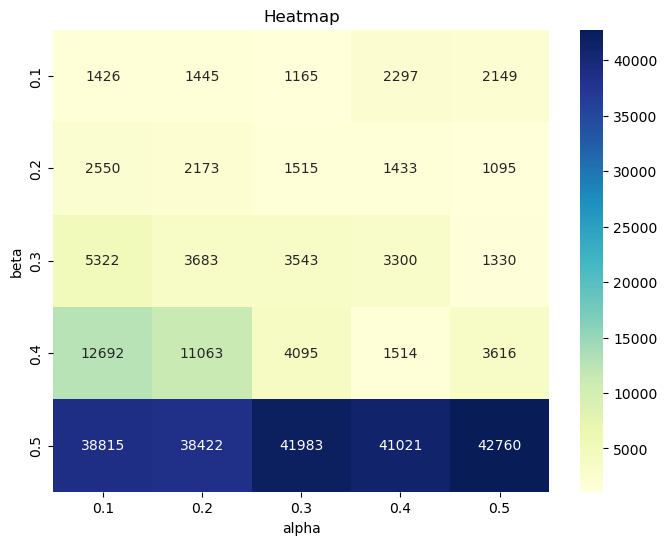

In [8]:
# Create heatmap
# Create a 2D array initialized with zeros
heatmap_data = np.zeros((5, 5))

x = rewards['alpha']
y = rewards['beta']
values = rewards['reward']

# Create a 2D grid for the heatmap
x_unique = sorted(set(x))
y_unique = sorted(set(y))

# Create a 2D array initialized with zeros
heatmap_data = np.zeros((len(y_unique), len(x_unique)))

# Fill the heatmap array with the values
for xi, yi, val in zip(x, y, values):
    x_index = x_unique.index(xi)
    y_index = y_unique.index(yi)
    heatmap_data[y_index, x_index] = val

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".0f", xticklabels=x_unique, yticklabels=y_unique, cmap="YlGnBu")
plt.xlabel('alpha')
plt.ylabel('beta')
plt.title('Heatmap')
plt.show()


# Approximate Solution with Deep-Q-Learning

## Training

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
from collections import deque

# Neural Network for the Q-function
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size, hidden_size=64):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, action_size)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        return self.out(x)

# Replay Buffer
class ReplayBuffer:
    def __init__(self, capacity=10000):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = map(np.array, zip(*batch))
        return state, action, reward, next_state, done
    
    def __len__(self):
        return len(self.buffer)

def normalize_state(state, max_sheep, max_money, max_years):
    # Normalize each component of the state to [0,1]
    n_sheep_norm = state['n_sheep'] / max_sheep
    money_norm = state['money'] / max_money
    year_norm = state['year'] / max_years
    return np.array([n_sheep_norm, money_norm, year_norm], dtype=np.float32)

def train_dqn(
    env,
    episodes=500,
    gamma=0.99,
    alpha=0.001,
    batch_size=64,
    epsilon_start=1.0,
    epsilon_end=0.01,
    decay_rate=0.001,
    target_update=10,
    memory_size=10000
):
    # Initialize environment parameters
    state_size = 3
    action_size = env.action_space.n

    # Create Q-networks
    q_network = QNetwork(state_size, action_size)
    target_network = QNetwork(state_size, action_size)
    target_network.load_state_dict(q_network.state_dict())  # Copy initial weights

    optimizer = optim.Adam(q_network.parameters(), lr=alpha)
    memory = ReplayBuffer(capacity=memory_size)

    epsilon = epsilon_start

    all_stats = []

    for episode in range(episodes):
        # Reset environment
        obs = env.reset(discretize=False)
        state = normalize_state(obs, env.max_sheep, env.max_money, env.max_years)
        done = False
        truncated = False
        total_reward = 0

        episode_stats = []
        
        while not done and not truncated:
            # Epsilon-greedy action selection
            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                with torch.no_grad():
                    state_t = torch.tensor([state], dtype=torch.float32)
                    q_values = q_network(state_t)
                    action = q_values.argmax(dim=1).item()
            
            next_obs, reward, done, truncated, info = env.step(action, discretize=False)
            next_state = normalize_state(next_obs, env.max_sheep, env.max_money, env.max_years)

            # Store transition in replay buffer
            memory.push(state, action, reward, next_state, done)
            
            state = next_state
            total_reward += reward

            # Training step
            if len(memory) > batch_size:
                states, actions, rewards, next_states, dones = memory.sample(batch_size)
                
                states_t = torch.tensor(states, dtype=torch.float32)
                actions_t = torch.tensor(actions, dtype=torch.long).unsqueeze(1)
                rewards_t = torch.tensor(rewards, dtype=torch.float32).unsqueeze(1)
                next_states_t = torch.tensor(next_states, dtype=torch.float32)
                dones_t = torch.tensor(dones, dtype=torch.float32).unsqueeze(1)

                # Compute current Q values
                current_q = q_network(states_t).gather(1, actions_t)

                # Compute next Q values from target network
                with torch.no_grad():
                    max_next_q = target_network(next_states_t).max(dim=1)[0].unsqueeze(1)
                    target_q = rewards_t + (gamma * max_next_q * (1 - dones_t))

                loss = nn.MSELoss()(current_q, target_q)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            step_stats = {
                'state': state,
                'action': action,
                'reward': reward,
                'done': done,
                'truncated': truncated,
                'info': info
            }
            episode_stats.append(step_stats)


        # Update epsilon
        epsilon = epsilon_end + (epsilon_start - epsilon_end)*np.exp(-decay_rate*episode)

        # Update target network
        if episode % target_update == 0:
            target_network.load_state_dict(q_network.state_dict())

        all_stats.append(episode_stats)
        
        print(f"Episode: {episode}, Total Reward: {total_reward}, Epsilon: {epsilon:.3f}")

    return q_network, all_stats

## Testing

In [ ]:
import torch
import numpy as np

def eval_agent_dqn(
    env,
    q_network,
    max_steps,
    n_eval_episodes,
    seed=None,
    disc_func=lambda x: x,
    render=False,
    discretize=False,
    device='cpu'
):
    """
    Evaluate a DQN agent.

    Args:
        env (gym.Env): The environment.
        q_network (nn.Module): The trained Q-network.
        max_steps (int): Maximum number of steps per episode.
        n_eval_episodes (int): Number of episodes to evaluate.
        seed (list or None): List of seeds, one for each episode, or None.
        disc_func (function): A function to discretize or process states if needed.
        render (bool): Whether to render the environment.
        discretize (bool): Whether the environment should return discretized observations.
        device (str): Device on which the network resides ('cpu' or 'cuda').
    
    Returns:
        all_stats (list): A list containing step-by-step information for each episode.
    """

    q_network.to(device)
    q_network.eval()

    def normalize_state(obs, max_sheep, max_money, max_years):
        n_sheep = obs['n_sheep'] / max_sheep
        money = obs['money'] / max_money
        year = obs['year'] / max_years
        return np.array([n_sheep, money, year], dtype=np.float32)

    episode_rewards = []
    all_stats = []

    for episode in range(n_eval_episodes):
        if seed is not None:
            observation = env.reset(seed=seed[episode], discretize=discretize)
        else:
            observation = env.reset(discretize=discretize)

        if isinstance(observation, dict):
            observation_raw = observation
        else:
            observation_raw = {
                'n_sheep': observation[0],
                'money': observation[1],
                'year': observation[2]
            }

        # Normalize the state before feeding into the network
        state_np = normalize_state(observation_raw, env.max_sheep, env.max_money, env.max_years)
        state = disc_func(state_np)

        done = False
        truncated = False
        total_rewards_ep = 0
        episode_stats = []

        for step in range(max_steps):
            # Convert state to a torch tensor and get the action
            state_tensor = torch.tensor([state], dtype=torch.float32, device=device)
            with torch.no_grad():
                q_values = q_network(state_tensor)
                action = q_values.argmax(dim=1).item()

            next_observation, reward, done, truncated, info = env.step(action, discretize=discretize)

            if isinstance(next_observation, dict):
                next_observation_raw = next_observation
            else:
                next_observation_raw = {
                    'n_sheep': next_observation[0],
                    'money': next_observation[1],
                    'year': next_observation[2]
                }

            next_state_np = normalize_state(next_observation_raw, env.max_sheep, env.max_money, env.max_years)
            next_state = disc_func(next_state_np)

            total_rewards_ep += reward

            step_stats = {
                'state': state,
                'action': action,
                'reward': reward,
                'done': done,
                'truncated': truncated,
                'info': info
            }
            episode_stats.append(step_stats)

            if render:
                env.render(action, reward, info)

            if done or truncated:
                break

            state = next_state

        episode_rewards.append(total_rewards_ep)
        all_stats.append(episode_stats)

    mean_reward = np.mean(episode_rewards)
    std_reward = np.std(episode_rewards)

    print(f"Mean Reward: {mean_reward}, Std Reward: {std_reward}")

    return all_stats


In [14]:
def get_total_episode_reward(episode):
    total_reward = sum(step['reward'] for step in episode)
    return total_reward

def get_mean_episode_reward(all_episodes):
    mean_episode_reward = np.mean([get_total_episode_reward(episode) for episode in all_episodes])
    return mean_episode_reward

In [46]:
from mdp import GymFarmEnv

env = GymFarmEnv(alpha=0.1, beta=0.5, max_sheep=10000, max_money=10000, max_years=30, space='discrete')
trained_q_net, train_stats = train_dqn(env, episodes=5000)

Episode: 0, Total Reward: -940, Epsilon: 1.000
Episode: 1, Total Reward: -830, Epsilon: 0.999
Episode: 2, Total Reward: -730, Epsilon: 0.998
Episode: 3, Total Reward: -880, Epsilon: 0.997
Episode: 4, Total Reward: -680, Epsilon: 0.996
Episode: 5, Total Reward: -880, Epsilon: 0.995
Episode: 6, Total Reward: -920, Epsilon: 0.994
Episode: 7, Total Reward: -890, Epsilon: 0.993
Episode: 8, Total Reward: -890, Epsilon: 0.992
Episode: 9, Total Reward: -750, Epsilon: 0.991
Episode: 10, Total Reward: -880, Epsilon: 0.990
Episode: 11, Total Reward: -840, Epsilon: 0.989
Episode: 12, Total Reward: -930, Epsilon: 0.988
Episode: 13, Total Reward: -900, Epsilon: 0.987
Episode: 14, Total Reward: -780, Epsilon: 0.986
Episode: 15, Total Reward: -810, Epsilon: 0.985
Episode: 16, Total Reward: -840, Epsilon: 0.984
Episode: 17, Total Reward: -820, Epsilon: 0.983
Episode: 18, Total Reward: -890, Epsilon: 0.982
Episode: 19, Total Reward: -650, Epsilon: 0.981
Episode: 20, Total Reward: -850, Epsilon: 0.980
Ep

Let's also see the training process here.

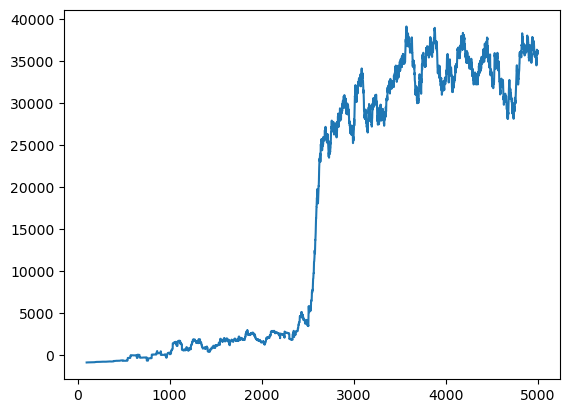

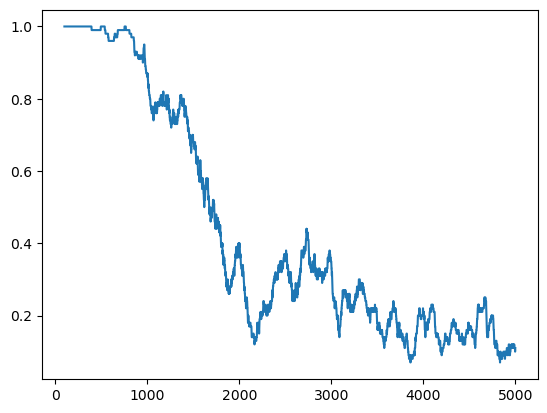

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_rewards(stats):
    # sns.set_theme(style="whitegrid")
    rewards = [get_total_episode_reward(episode) for episode in stats]
    plot = plt.plot(rewards)
    plt.show()
    return plot 

def plot_rewards_moving_avg(stats):
    # sns.set_theme(style="whitegrid")
    rewards = [get_total_episode_reward(episode) for episode in stats]
    rewards = pd.Series(rewards)
    smoothed_rewards = rewards.rolling(window=100).mean()  # 100-point moving average
    plot = plt.plot(smoothed_rewards)
    plt.show()
    return plot

def plot_truncated_moving_avg(stats):
    truncated_list = [sum(step['truncated'] for step in episode) > 0 for episode in stats]
    truncated_list = pd.Series(truncated_list)
    smoothed_truncated_list = truncated_list.rolling(window=100).mean()  # 100-point moving average
    plot = plt.plot(smoothed_truncated_list)
    plt.show()
    return plot

plot_rewards_moving_avg(train_stats)
plot_truncated_moving_avg(train_stats)


### Performance

We test the performance on the same environment as in the tabular performance test. 

(Sidenote: max_steps here and in other function is a remnant from earlier code and is not relevant at all)

In [47]:
test_stats = eval_agent_dqn(env, trained_q_net, max_steps=1000, n_eval_episodes=1000)

Mean Reward: 39633.34, Std Reward: 16966.217393526465


### Actions

Let's see which actions are taken at which steps. To do that we take the action statistics of the testing process and calculate proportions of actions taken in each step over the 1000 episodes played. Action 0 represents buying a sheep and action 1 growing wheat.

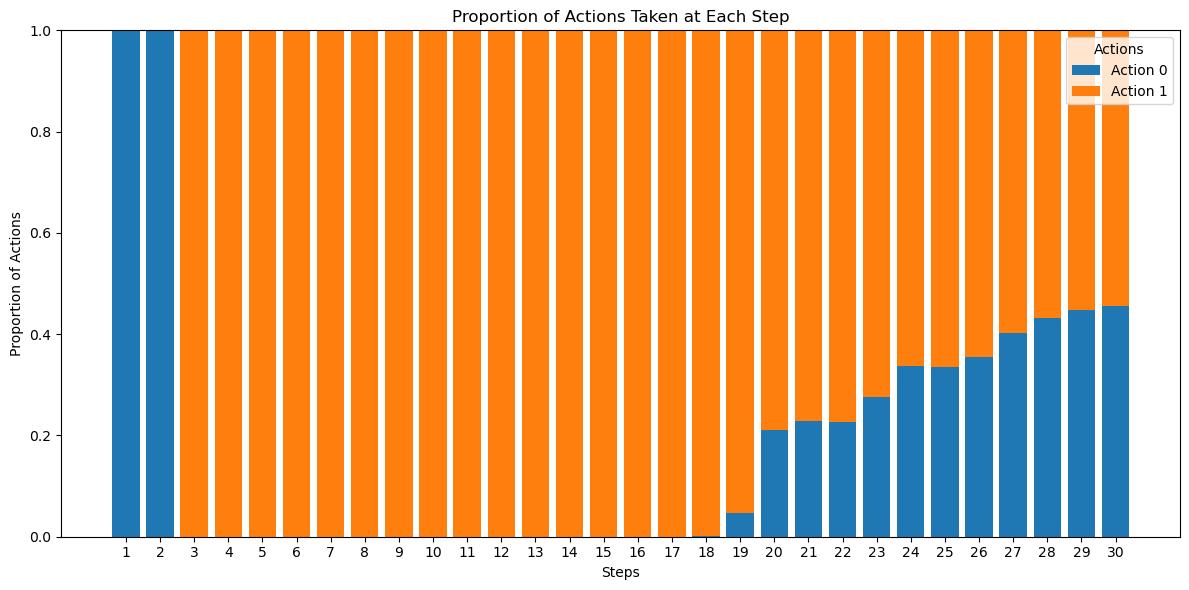

In [48]:
# We want the overall proportions of actions taken in each step for the episodes in the test statistics

import matplotlib.pyplot as plt
import numpy as np

step_action_counts = [[0, 0] for _ in range(30)]

for episode in test_stats:
    for step in range(len(episode)):
        if episode[step]['action'] == 0:
            step_action_counts[step][0] += 1
        else:
            step_action_counts[step][1] += 1

step_action_0_prop = np.array([step[0] / sum(step) for step in step_action_counts])
step_action_1_prop = np.array([step[1] / sum(step) for step in step_action_counts])
step_indices = np.arange(1, 31)

# Plotting the stacked bar chart
plt.figure(figsize=(12, 6))
plt.bar(step_indices, step_action_0_prop, label="Action 0")
plt.bar(step_indices, step_action_1_prop, bottom=step_action_0_prop, label="Action 1")

# Chart labels and title
plt.xlabel("Steps")
plt.ylabel("Proportion of Actions")
plt.title("Proportion of Actions Taken at Each Step")
plt.xticks(step_indices)
plt.legend(title="Actions")
plt.tight_layout()
plt.show()

### Evaluating performance for different environment parameters

We would like to see how the performance of our algorithm varies for different environment parameters.

In [18]:
alphas = [0.1, 0.2, 0.3, 0.4, 0.5]
betas = [0.5, 0.4, 0.3, 0.2, 0.1]

rewards = {
    'alpha': [],
    'beta': [],
    'reward': []
}

for alpha in alphas:
    for beta in betas:

        env = GymFarmEnv(alpha=alpha, beta=beta, max_sheep=10000, max_money=10000, max_years=30, space='discrete')
        trained_q_net, train_stats = train_dqn(env, episodes=5000)
        test_stats = eval_agent_dqn(env, trained_q_net, max_steps=1000, n_eval_episodes=100) 
        mean_reward = get_mean_episode_reward(test_stats)

        rewards['alpha'].append(alpha)
        rewards['beta'].append(beta)
        rewards['reward'].append(mean_reward)

# Create heatmap
sns.heatmap(rewards['reward'], xticklabels=rewards['alpha'], yticklabels=rewards['beta'], annot=True, fmt=".2f", cmap="viridis")
plt.xlabel("Alpha")
plt.ylabel("Beta")
plt.title("Reward Heatmap")
plt.show()



Episode: 0, Total Reward: -970, Epsilon: 1.000
Episode: 1, Total Reward: -700, Epsilon: 0.999
Episode: 2, Total Reward: -910, Epsilon: 0.998
Episode: 3, Total Reward: -940, Epsilon: 0.997
Episode: 4, Total Reward: -810, Epsilon: 0.996
Episode: 5, Total Reward: -900, Epsilon: 0.995
Episode: 6, Total Reward: -910, Epsilon: 0.994
Episode: 7, Total Reward: -920, Epsilon: 0.993
Episode: 8, Total Reward: -950, Epsilon: 0.992
Episode: 9, Total Reward: -900, Epsilon: 0.991
Episode: 10, Total Reward: -970, Epsilon: 0.990
Episode: 11, Total Reward: -890, Epsilon: 0.989
Episode: 12, Total Reward: -750, Epsilon: 0.988
Episode: 13, Total Reward: -10, Epsilon: 0.987
Episode: 14, Total Reward: -910, Epsilon: 0.986
Episode: 15, Total Reward: -970, Epsilon: 0.985
Episode: 16, Total Reward: -930, Epsilon: 0.984
Episode: 17, Total Reward: -930, Epsilon: 0.983
Episode: 18, Total Reward: -870, Epsilon: 0.982
Episode: 19, Total Reward: -750, Epsilon: 0.981
Episode: 20, Total Reward: -820, Epsilon: 0.980
Epi

IndexError: Inconsistent shape between the condition and the input (got (25, 1) and (25,))

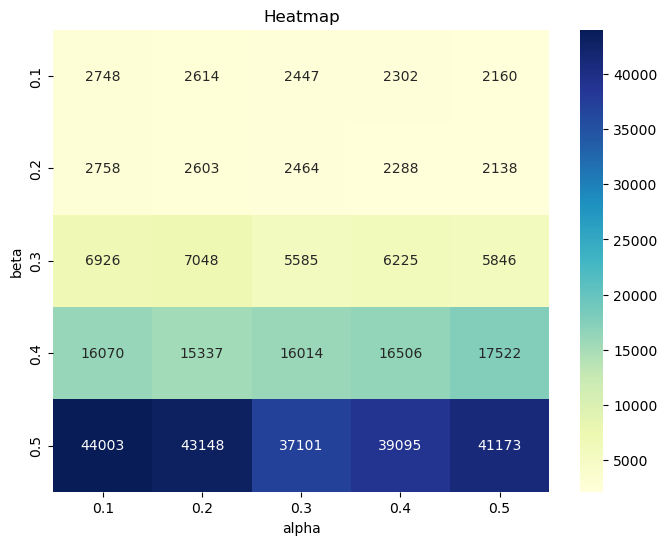

In [19]:
# Create heatmap
# Create a 2D array initialized with zeros
heatmap_data = np.zeros((5, 5))

x = rewards['alpha']
y = rewards['beta']
values = rewards['reward']

# Create a 2D grid for the heatmap
x_unique = sorted(set(x))
y_unique = sorted(set(y))

# Create a 2D array initialized with zeros
heatmap_data = np.zeros((len(y_unique), len(x_unique)))

# Fill the heatmap array with the values
for xi, yi, val in zip(x, y, values):
    x_index = x_unique.index(xi)
    y_index = y_unique.index(yi)
    heatmap_data[y_index, x_index] = val

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".0f", xticklabels=x_unique, yticklabels=y_unique, cmap="YlGnBu")
plt.xlabel('alpha')
plt.ylabel('beta')
plt.title('Heatmap')
plt.show()
